In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Keras Imports
from keras import datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SeparableConv2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
from tensorflow.keras import mixed_precision
# Enable mixed precision
mixed_precision.set_global_policy('mixed_float16')

# Load Data

In [4]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

In [5]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [6]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

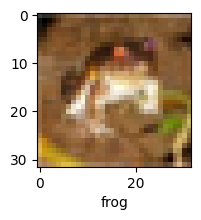

In [7]:
plot_sample(X_train, y_train, 0)

In [8]:
X_train.shape

(50000, 32, 32, 3)

# Normalize training data before training the neural net

Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. Hence to normalize in 0-->1 range, we need to divide it by 255

In [9]:
X_train = X_train/255
X_test = X_test/255

# Now build the Sequential Model and add layers into it

In [10]:
# Define a learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,  # starting learning rate
    decay_steps=10000,           # number of steps before decay
    decay_rate=0.9,              # decay factor
    staircase=True             # use discrete intervals for decay
)

# Use Adam optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Use sparse categorical crossentropy with label smoothing to help generalization.
loss = SparseCategoricalCrossentropy(from_logits=False)

# Improved CNN model for CIFAR-10
model = Sequential([
    Input(shape=(32, 32, 3)),
    
    # Block 1: Use SeparableConv2D for efficiency
    SeparableConv2D(32, kernel_size=3, padding='same', activation=LeakyReLU(negative_slope=0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Block 2
    SeparableConv2D(64, kernel_size=3, padding='same', activation=LeakyReLU(negative_slope=0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    # Instead of a third block, use Global Average Pooling to reduce parameters
    GlobalAveragePooling2D(),
    
    # Final classification layer
    Dense(10, activation='softmax')
])

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.summary()

2025-03-22 15:31:23.473939: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-03-22 15:31:23.473993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-03-22 15:31:23.474002: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-03-22 15:31:23.474037: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-22 15:31:23.474054: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 32, 32, 32)     │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 16, 16, 64)     │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,589 (14.02 KB)

 Trainable params: 3,397 (13.27 KB)

 Non-trainable params: 192 (768.00 B)

In [11]:
estimator = KerasClassifier(model=model, epochs=10, batch_size=5, verbose=1)
estimator.fit(X_train, y_train, epochs=10)

Epoch 1/10


2025-03-22 15:31:25.122906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 125s 12ms/step - accuracy: 0.3019 - loss: 1.9003
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 120s 12ms/step - accuracy: 0.4258 - loss: 1.6053
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 119s 12ms/step - accuracy: 0.4574 - loss: 1.5148
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 117s 12ms/step - accuracy: 0.4735 - loss: 1.4716
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 133s 13ms/step - accuracy: 0.4908 - loss: 1.4352
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 192s 19ms/step - accuracy: 0.4930 - loss: 1.4140
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 128s 13ms/step - accuracy: 0.5019 - loss: 1.3951
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 164s 16ms/step - accuracy: 0.5066 - loss: 1.3835
Epoch 9/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 156s 16ms/step - accuracy: 0.5086 - loss: 1.3711
Epoch 10/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 121s 12ms/step - accuracy: 0.5162 - loss: 1.3549


KerasClassifier(
	model=<Sequential name=sequential, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=5
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)

# Evaluation of Model

In [12]:
acc = estimator.score(X_test, y_test)
print('The accuracy is' , round(acc, 3))

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
The accuracy is 0.506


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


Text(95.72222222222221, 0.5, 'Truth')

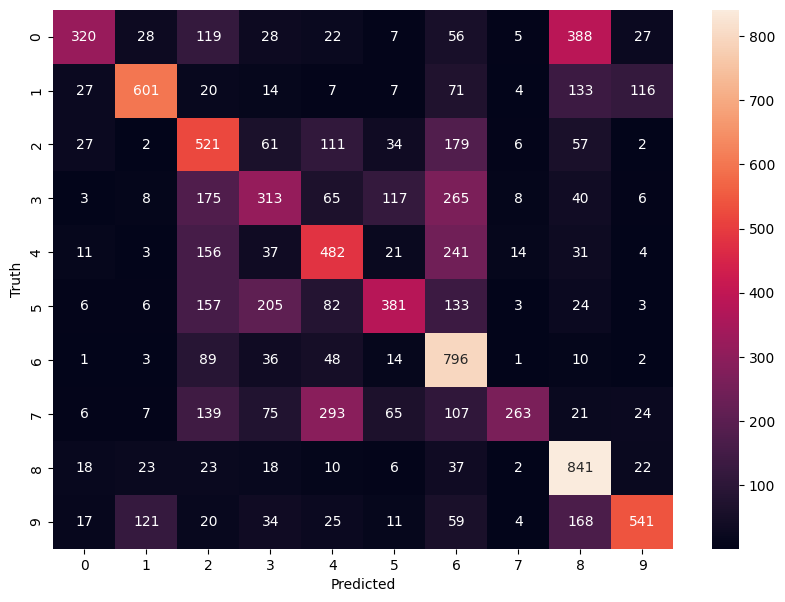

In [13]:
import tensorflow as tf

y_predicted_labels = estimator.predict(X_test)
# y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [14]:
from sklearn.metrics import confusion_matrix , classification_report

print("Classification Report: \n", classification_report(y_test, y_predicted_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.73      0.32      0.45      1000
           1       0.75      0.60      0.67      1000
           2       0.37      0.52      0.43      1000
           3       0.38      0.31      0.34      1000
           4       0.42      0.48      0.45      1000
           5       0.57      0.38      0.46      1000
           6       0.41      0.80      0.54      1000
           7       0.85      0.26      0.40      1000
           8       0.49      0.84      0.62      1000
           9       0.72      0.54      0.62      1000

    accuracy                           0.51     10000
   macro avg       0.57      0.51      0.50     10000
weighted avg       0.57      0.51      0.50     10000



# ResNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

In [2]:
# Check for MPS availability (for Apple Silicon)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


In [3]:
# Define image transformations for ResNet18.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet models expect 224x224 images
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # Use the normalization values from ImageNet.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Load the Caltech101 dataset from a local directory.
dataset = torchvision.datasets.CIFAR10(root='./data', download=True, transform=transform)

# Use dataset.categories to determine the number of classes.
num_classes = len(dataset.classes)
print("Number of classes:", num_classes)

# Split the dataset into training (80%) and testing (20%) sets.
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

100%|████████████████████████████████████████| 170M/170M [00:06<00:00, 27.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Number of classes: 10


In [4]:
# Load a pre-trained ResNet18 model.
model = torchvision.models.resnet18()

# Replace the final fully-connected layer to adapt for Caltech101.
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/Users/utkarshgoyal/Desktop/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/utkarshgoyal/Desktop/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# Training loop.
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.5105
Epoch [2/10], Loss: 0.2194
Epoch [3/10], Loss: 0.1084
Epoch [4/10], Loss: 0.0701
Epoch [5/10], Loss: 0.0610
Epoch [6/10], Loss: 0.0493
Epoch [7/10], Loss: 0.0453
Epoch [8/10], Loss: 0.0426
Epoch [9/10], Loss: 0.0376
Epoch [10/10], Loss: 0.0329


In [6]:
# Evaluation on the test set
model.eval()
correct = 0
total   = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 89.99%


In [7]:
torch.save(model.state_dict(), "model.pth")